# Question 1 [15 pts]: Fit a logistic regression model using all variable

A logistic regression model is used to predict whether a song would reach top 10 on the BillBoard Hot 100 Chart. This analysis was done by using all musical features in the data provided. This model was able to achieve an accuracy of 74.35% and an AUC of 0.82, meaning that the model is able to predict 3 quarters of the prediction

Steps taken for the analysis:
1. Importing the music dataset - 7573 records and 39 fields
2. Checking the data for any missing values, missing values can cause a bias in the model and could potentially reduce the accuracy and effective of the model- No null values were found
3. Checking the data for outliers, Models, like linear and logistic regression, optimize for minimizing error, they might get pulled towards these outlier points, which can lead to reducing the accuracy of the model. In this analysis we used the IQR method to remove outliers. After reviewing the loudness, tempo,energy and pitch features, there are outliers in the dataset and are removed for the the model.
4. Conversion of object variables to numerical. Models are only able to use numerical variables, since song and artists are objects, they will need to be converted to numerical using one hot encoding. With this converted to numerical, we will be able to use all variables for the model
5. Handling high collinear records - Removing records with high collinear records
5. Splitting the data into train and test - anything before 2009 will be our train data and songs in 2010 will be used to predict whether or not a song will make top 10.
6. Performing a logistic Regression on Train data - Year, timesignature_confidence, loudness, tempo_confidence, energy, pitch, timbre and artist name all have a p value < 0.05 meaning they are significant to the model
7. Performing a Confusion Matrix on test data:
    True Negatives = 4561 of making it top 10
    False Positives = 1580 of making it top 10
    False Negative = 267 of making it top 10
    True Positives = 793 of making it top 10

    1580 cases where it was classified as making it top 10 - Type 1 Error
    267 Cases where it was classified as not making it top 10 when it should have - Type 2 Error

    Our model indicates that the model has a tendency to over predict success (Making top 10). For a music company, this might mean spending marketing resources on songs that are not actually likely to succeed.
    For type 2, Missing out on potential hits could mean lost revenue opportunities.

8. Performing an ROC Curve on train data, provides insights into how well the model distinguishes between the positive and negative classes, independent of the decision threshold.
    •	AUC = 0.5: No discriminative power (same as random guessing).
	•	AUC < 0.5: Worse than random guessing (rare in practice).
	•	AUC > 0.5: The model has some discriminatory power. Higher AUC values indicate better model performance.

    AUC = 0.82 chance that the model will rank a randomly chosen positive instance (Top 10 song) higher than a randomly chosen negative instance (not Top 10 song). This is a good indication that your model has high discriminatory power, effectively distinguishing between top 10 and non-top 10.

These findings provide valuable insights for music producers and marketers to optimize their strategies for promoting potential hit songs.
To make the model more accurate, we will need to further tune it to remove features with p-value > 0.05 and 

Code below for Q1:


Columns with more than 0 null values:
Series([], dtype: int64)
Index(['year', 'timesignature', 'timesignature_confidence', 'loudness',
       'tempo', 'tempo_confidence', 'key', 'key_confidence', 'energy', 'pitch',
       'timbre_0_min', 'timbre_0_max', 'timbre_1_min', 'timbre_1_max',
       'timbre_2_min', 'timbre_2_max', 'timbre_3_min', 'timbre_3_max',
       'timbre_4_min', 'timbre_4_max', 'timbre_5_min', 'timbre_5_max',
       'timbre_6_min', 'timbre_6_max', 'timbre_7_min', 'timbre_7_max',
       'timbre_8_min', 'timbre_8_max', 'timbre_9_min', 'timbre_9_max',
       'timbre_10_min', 'timbre_10_max', 'timbre_11_min', 'timbre_11_max',
       'Top10'],
      dtype='object')

Initial class distribution in df['Top10']:
Top10
0    6455
1    1119
Name: count, dtype: int64

Number of rows before outlier removal: 7574


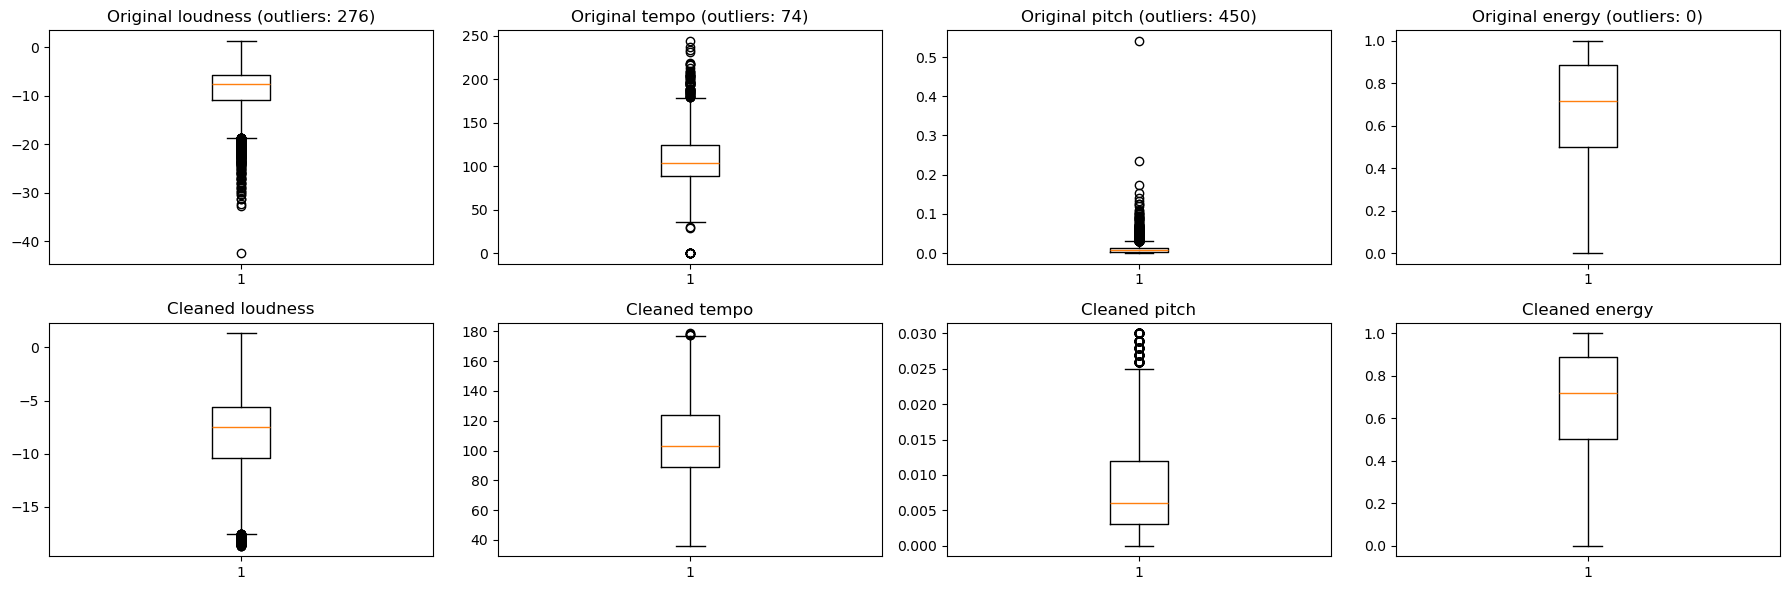


Number of rows after removing outliers: 7574

Class distribution in train_df['Top10']:
Top10
0    6141
1    1060
Name: count, dtype: int64

Variance Inflation Factor (VIF) for each feature:
                     Feature          VIF
0                       year  2206.672881
1              timesignature    62.852070
2   timesignature_confidence    17.037232
3                   loudness    54.252610
4                      tempo    21.224317
5           tempo_confidence     6.272088
6                        key     3.293731
7             key_confidence     3.669570
8                     energy    32.503693
9                      pitch     2.412122
10              timbre_0_min     1.348089
11              timbre_0_max  1365.854423
12              timbre_1_min     6.492180
13              timbre_1_max    20.377185
14              timbre_2_min    18.623901
15              timbre_2_max    13.440116
16              timbre_3_min     9.078410
17              timbre_3_max    10.470359
18         

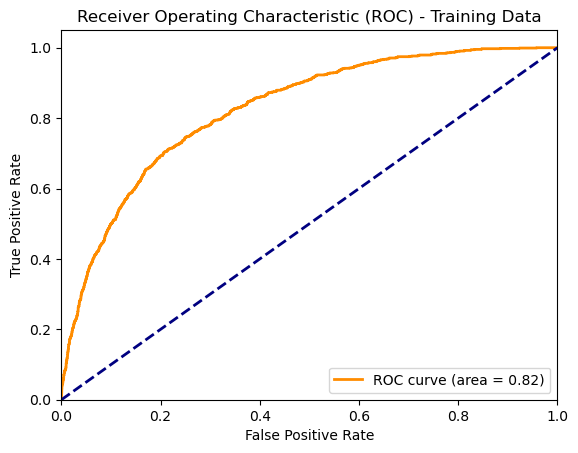

In [35]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE  # Import SMOTE for oversampling
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from scipy.stats import norm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the dataset
df = pd.read_csv("MusicData.csv", encoding='ISO-8859-1')

# Display count of null values for columns with more than 0 nulls
null_counts = df.isnull().sum()
print("\nColumns with more than 0 null values:")
print(null_counts[null_counts > 0])

# Removing unnecessary variables
df = df.drop(columns=['artistname', 'songtitle', 'songID', 'artistID'])
print(df.columns)

# Show initial class distribution to understand the problem
print("\nInitial class distribution in df['Top10']:")
print(df['Top10'].value_counts())

# Show count before outlier removal
print(f"\nNumber of rows before outlier removal: {df.shape[0]}")

# Improved function to identify and remove outliers using IQR
def identify_and_remove_outliers_iqr(df, column, iqr_factor=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_factor * IQR
    upper_bound = Q3 + iqr_factor * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    df_no_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return outliers, df_no_outliers

# List of columns to check for outliers
columns_to_check = ['loudness', 'tempo', 'pitch', 'energy']

# Dictionary to store outliers
outliers_info = {}

# Apply outlier removal to all specified columns and visualize the effect
plt.figure(figsize=(18, 6))
for i, col in enumerate(columns_to_check, start=1):
    # Identify and remove outliers
    outliers, df_no_outliers = identify_and_remove_outliers_iqr(df, col)
    outliers_info[col] = outliers

    # Plotting boxplot for original data
    plt.subplot(2, len(columns_to_check), i)
    plt.boxplot(df[col], vert=True)
    plt.title(f'Original {col} (outliers: {len(outliers)})')
    
    # Plotting boxplot for data after outlier removal
    plt.subplot(2, len(columns_to_check), i + len(columns_to_check))
    plt.boxplot(df_no_outliers[col], vert=True)
    plt.title(f'Cleaned {col}')

plt.tight_layout()
plt.show()

# Update the main dataframe with outlier removal results
df = df_no_outliers

# Display number of rows after removing outliers
print(f"\nNumber of rows after removing outliers: {df.shape[0]}")

# Split data by year: use only train set
train_df = df[df['year'] <= 2009]

# Check class distribution after splitting
print("\nClass distribution in train_df['Top10']:")
print(train_df['Top10'].value_counts())

# Prepare the training data
X_train = train_df.drop(columns="Top10")
y_train = train_df["Top10"]

# Add a constant column for the intercept for statsmodels logistic regression
X_train_sm = sm.add_constant(X_train)

# Normalize features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Check for multicollinearity using VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

print("\nVariance Inflation Factor (VIF) for each feature:")
print(vif_data)

# Removing features with high VIF if necessary
high_vif_features = vif_data[vif_data["VIF"] > 10]["Feature"]
X_train = X_train.drop(columns=high_vif_features)

# Fit the model using sklearn with regularization (L2 by default)
log_reg = LogisticRegression(max_iter=10000, solver='lbfgs')
log_reg.fit(X_train_scaled, y_train)

# Fit the model using statsmodels' logistic regression
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

# Displaying the summary
print("\nLogistic Regression Summary (Statsmodels):")
print(result.summary())

# Make predictions on the training set
y_pred_prob = log_reg.predict_proba(X_train_scaled)[:, 1]

predicted_classes = (y_pred_prob > 0.15).astype(int)

# Creating a confusion matrix
conf_matrix = confusion_matrix(y_train, predicted_classes)

# Computing the accuracy rate on the training set
train_accuracy = accuracy_score(y_train, predicted_classes)

print("\nConfusion Matrix:")
print(conf_matrix)
print(f"Train Accuracy: {train_accuracy:.4f}")

precision = precision_score(y_train, predicted_classes)
recall = recall_score(y_train, predicted_classes)
f1 = f1_score(y_train, predicted_classes)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# ROC Curve and AUC for training data
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Training Data')
plt.legend(loc="lower right")
plt.show()

### Question 2 [15 pts]: Predict the popularity of records in the testing set.
A logistic regression model is used to predict whether a song would reach top 10 on the BillBoard Hot 100 Chart. This analysis was done by using all musical features in the data provided. This model was able to achieve an accuracy of 82.84% and an AUC of 0.85 with the test data.

Steps taken for the analysis:
1. Importing the music dataset - 7573 records and 39 fields
2. Checking the data for any missing values, missing values can cause a bias in the model and could potentially reduce the accuracy and effective of the model- No null values were found
3. Checking the data for outliers, Models, like linear and logistic regression, optimize for minimizing error, they might get pulled towards these outlier points, which can lead to reducing the accuracy of the model. In this analysis we used the IQR method to remove outliers. After reviewing the loudness, tempo,energy and pitch features, there are outliers in the dataset and are removed for the the model.
4. Conversion of object variables to numerical. Models are only able to use numerical variables, since song and artists are objects, they will need to be converted to numerical using one hot encoding. With this converted to numerical, we will be able to use all variables for the model
5. Handling high collinear records - Removing records with high collinear records
5. Splitting the data into train and test - anything before 2009 will be our train data and songs in 2010 will be used to predict whether or not a song will make top 10.
6. Performing a logistic Regression on Train data - Year, timesignature_confidence, loudness, tempo_confidence, energy, pitch, timbre and artist name all have a p value < 0.05 meaning they are significant to the model
7. Performing a Confusion Matrix on train data:
    True Negatives = 4561 of making it top 10
    False Positives = 1580 of making it top 10
    False Negative = 267 of making it top 10
    True Positives = 793 of making it top 10

    1580 cases where it was classified as making it top 10 - Type 1 Error
    267 Cases where it was classified as not making it top 10 when it should have - Type 2 Error

    Our model indicates that the model has a tendency to over predict success (Making top 10). For a music company, this might mean spending marketing resources on songs that are not actually likely to succeed.
    For type 2, Missing out on potential hits could mean lost revenue opportunities.

    Performing a Confusion Matrix on test data:
    True Negatives = 272 of making it top 10
    False Positives = 42 of making it top 10
    False Negative = 22 of making it top 10
    True Positives = 37 of making it top 10

    42 cases where it was classified as making it top 10 - Type 1 Error
    22 Cases where it was classified as not making it top 10 when it should have - Type 2 Error

    Same as the train data above, even though the accuracy is better in the test. Our model indicates that the model has a tendency to over predict success (Making top 10). For a music company, this might mean spending marketing resources on songs that are not actually likely to succeed.
    For type 2, Missing out on potential hits could mean lost revenue opportunities.
    
8. Performing an ROC Curve on test data, provides insights into how well the model distinguishes between the positive and negative classes, independent of the decision threshold.
    •	AUC = 0.5: No discriminative power (same as random guessing).
	•	AUC < 0.5: Worse than random guessing (rare in practice).
	•	AUC > 0.5: The model has some discriminatory power. Higher AUC values indicate better model performance.

    AUC = 0.82 chance that the model will rank a randomly chosen positive instance (Top 10 song) higher than a randomly chosen negative instance (not Top 10 song). This is a good indication that your model has high discriminatory power, effectively distinguishing between top 10 and non-top 10.

These findings provide valuable insights for music producers and marketers to optimize their strategies for promoting potential hit songs.
To make the model more accurate, we will need to further tune it to remove features with p-value > 0.05 and 

Code below for Q2:


Columns with more than 0 null values:
Series([], dtype: int64)
Index(['year', 'timesignature', 'timesignature_confidence', 'loudness',
       'tempo', 'tempo_confidence', 'key', 'key_confidence', 'energy', 'pitch',
       'timbre_0_min', 'timbre_0_max', 'timbre_1_min', 'timbre_1_max',
       'timbre_2_min', 'timbre_2_max', 'timbre_3_min', 'timbre_3_max',
       'timbre_4_min', 'timbre_4_max', 'timbre_5_min', 'timbre_5_max',
       'timbre_6_min', 'timbre_6_max', 'timbre_7_min', 'timbre_7_max',
       'timbre_8_min', 'timbre_8_max', 'timbre_9_min', 'timbre_9_max',
       'timbre_10_min', 'timbre_10_max', 'timbre_11_min', 'timbre_11_max',
       'Top10'],
      dtype='object')

Initial class distribution in df['Top10']:
Top10
0    6455
1    1119
Name: count, dtype: int64

Number of rows before outlier removal: 7574


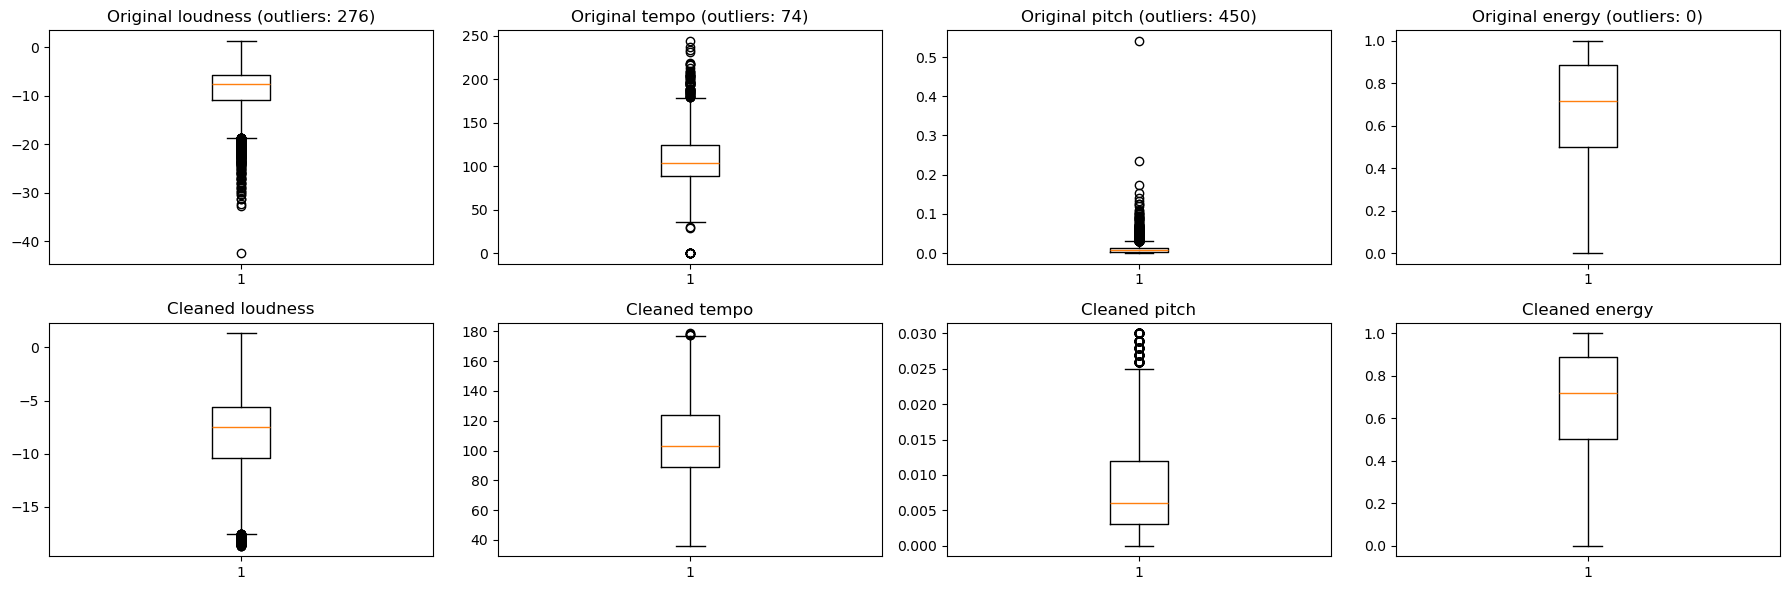


Number of rows after removing outliers: 7574

Class distribution in train_df['Top10']:
Top10
0    6141
1    1060
Name: count, dtype: int64

Training Confusion Matrix:
[[4561 1580]
 [ 267  793]]
Train Accuracy: 0.7435
Train Precision: 0.3342
Train Recall: 0.7481
Train F1 Score: 0.4620


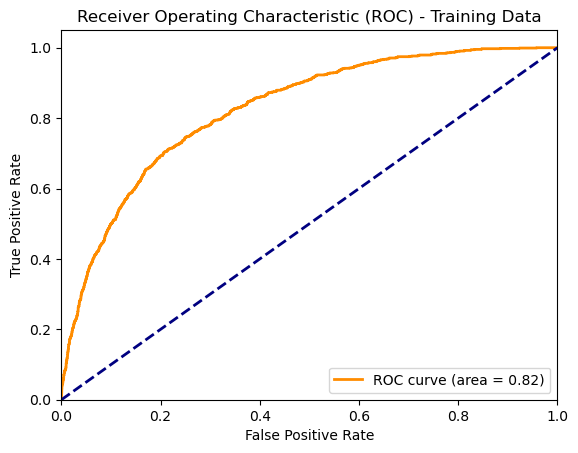


Testing Confusion Matrix:
[[272  42]
 [ 22  37]]
Test Accuracy: 0.8284
Test Precision: 0.4684
Test Recall: 0.6271
Test F1 Score: 0.5362


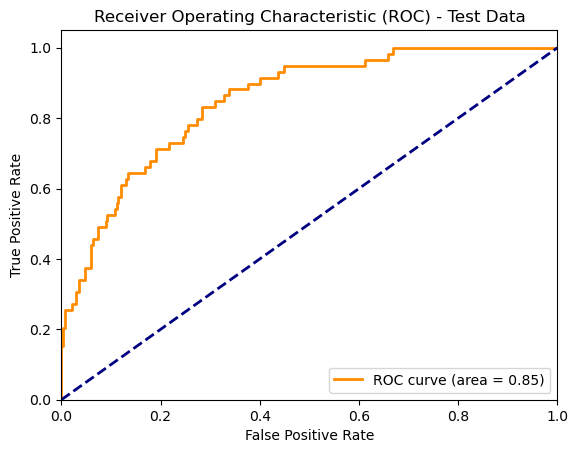

In [36]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE  # Import SMOTE for oversampling
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from scipy.stats import norm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the dataset
df = pd.read_csv("MusicData.csv", encoding='ISO-8859-1')

# Display count of null values for columns with more than 0 nulls
null_counts = df.isnull().sum()
print("\nColumns with more than 0 null values:")
print(null_counts[null_counts > 0])

# Removing unnecessary variables
df = df.drop(columns=['artistname', 'songtitle', 'songID', 'artistID'])
print(df.columns)

# Show initial class distribution to understand the problem
print("\nInitial class distribution in df['Top10']:")
print(df['Top10'].value_counts())

# Show count before outlier removal
print(f"\nNumber of rows before outlier removal: {df.shape[0]}")

# Improved function to identify and remove outliers using IQR
def identify_and_remove_outliers_iqr(df, column, iqr_factor=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_factor * IQR
    upper_bound = Q3 + iqr_factor * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    df_no_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return outliers, df_no_outliers

# List of columns to check for outliers
columns_to_check = ['loudness', 'tempo', 'pitch', 'energy']

# Dictionary to store outliers
outliers_info = {}

# Apply outlier removal to all specified columns and visualize the effect
plt.figure(figsize=(18, 6))
for i, col in enumerate(columns_to_check, start=1):
    # Identify and remove outliers
    outliers, df_no_outliers = identify_and_remove_outliers_iqr(df, col)
    outliers_info[col] = outliers

    # Plotting boxplot for original data
    plt.subplot(2, len(columns_to_check), i)
    plt.boxplot(df[col], vert=True)
    plt.title(f'Original {col} (outliers: {len(outliers)})')
    
    # Plotting boxplot for data after outlier removal
    plt.subplot(2, len(columns_to_check), i + len(columns_to_check))
    plt.boxplot(df_no_outliers[col], vert=True)
    plt.title(f'Cleaned {col}')

plt.tight_layout()
plt.show()

# Update the main dataframe with outlier removal results
df = df_no_outliers

# Display number of rows after removing outliers
print(f"\nNumber of rows after removing outliers: {df.shape[0]}")

# Split data by year: train up to 2009, test on 2010
train_df = df[df['year'] <= 2009]
test_df = df[df['year'] == 2010]

# Check class distribution after splitting
print("\nClass distribution in train_df['Top10']:")
print(train_df['Top10'].value_counts())

# Prepare the training data
X_train = train_df.drop(columns="Top10")
y_train = train_df["Top10"]

# Prepare the testing data
X_test = test_df.drop(columns="Top10")
y_test = test_df["Top10"]

# Normalize features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Fit the model using sklearn with regularization (L2 by default)
log_reg = LogisticRegression(max_iter=10000, solver='lbfgs')
log_reg.fit(X_train_scaled, y_train)

# Evaluate on the training set
y_train_pred_prob = log_reg.predict_proba(X_train_scaled)[:, 1]
y_train_pred = (y_train_pred_prob > 0.15).astype(int)
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

print("\nTraining Confusion Matrix:")
print(train_conf_matrix)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train Recall: {train_recall:.4f}")
print(f"Train F1 Score: {train_f1:.4f}")

# ROC Curve and AUC for training data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Training Data')
plt.legend(loc="lower right")
plt.show()

# Evaluate on the test set
y_test_pred_prob = log_reg.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_pred_prob > 0.15).astype(int)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("\nTesting Confusion Matrix:")
print(test_conf_matrix)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# ROC Curve and AUC for test data
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Test Data')
plt.legend(loc="lower right")
plt.show()

### Question 3 [15 pts]:  Generate the ROC curve

AUC = 0.5: No discriminative power (same as random guessing).
AUC < 0.5: Worse than random guessing (rare in practice).
AUC > 0.5: The model has some discriminatory power. Higher AUC values indicate better model performance.

Since both the train and test date show greater than 0.5, this indicates that the model has some discriminatory power. The test data has an 85% chance that the model will rank a randomly chosen positive instance (Top 10 song) higher than a randomly chosen negative instance (not Top 10 song). 

Code below for Q3:

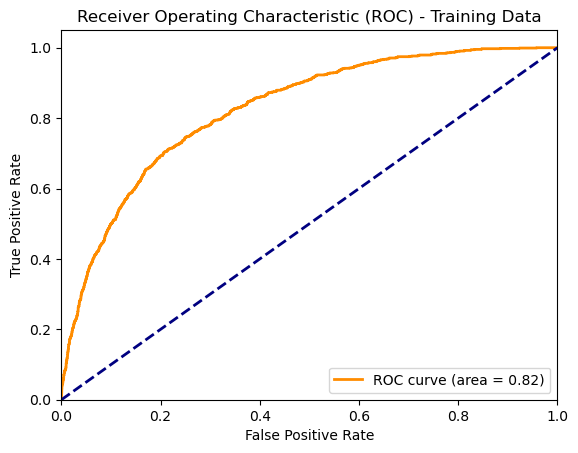

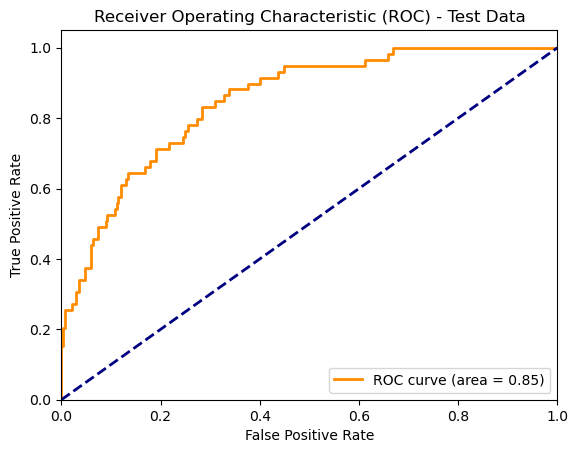

In [12]:
# ROC Curve and AUC for training data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Training Data')
plt.legend(loc="lower right")
plt.show()

# ROC Curve and AUC for test data
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Test Data')
plt.legend(loc="lower right")
plt.show()

### Question 4: [30 pts]:  Improve the prediction performance of your model. For example, you may try transforming some predictors, and/or perform variable selection, or other approaches. Explain all steps! 

The way I have improved the model is by keeping only significant features and removing from the features that have a p-value > 0.05. By removing insignificant features we have improved the train accuracy from 74% to 86% and test accuracy from 82% to 85%. 
We have also reduced the error of making a type 1 error, from 42 records to 0. This is important because a music company, this might mean spending marketing resources on songs that are not actually likely to succeed.
While type 2 error, yes it has increased but we will just miss out on opportunity cost.

Steps taken for the analysis:
1. Importing the music dataset - 7573 records and 39 fields
2. Checking the data for any missing values, missing values can cause a bias in the model and could potentially reduce the accuracy and effective of the model- No null values were found
3. Checking the data for outliers, Models, like linear and logistic regression, optimize for minimizing error, they might get pulled towards these outlier points, which can lead to reducing the accuracy of the model. In this analysis we used the IQR method to remove outliers. After reviewing the loudness, tempo,energy and pitch features, there are outliers in the dataset and are removed for the the model.
4. Conversion of object variables to numerical. Models are only able to use numerical variables, since song and artists are objects, they will need to be converted to numerical using one hot encoding. With this converted to numerical, we will be able to use all variables for the model
5. Handling high collinear records - Removing records with high collinear records
6. Splitting the data into train and test - anything before 2009 will be our train data and songs in 2010 will be used to predict whether or not a song will make top 10.
7. Performing a logistic Regression on Train data - Year, timesignature_confidence, loudness, tempo_confidence, energy, pitch, timbre and artist name all have a p value < 0.05 meaning they are significant to the model
8. Removing columns that have a P-Value > 0.05 and only keeping significant value. This will help in reducing noise which is caused by irrelevant or insignificant features that do not contribute meaningful information. By keeping only significant features, we only have features which have meaningful relationships.
Below are the columns we keep:
'year', 'timesignature_confidence', 'loudness', 'tempo_confidence', 'key_confidence', 'energy', 'pitch', 'timbre_0_min', 'timbre_0_max', 'timbre_1_min', 'timbre_3_max', 'timbre_4_min', 'timbre_4_max', 'timbre_5_min', 'timbre_6_min', 'timbre_6_max', 'timbre_7_min', 'timbre_10_max', 'timbre_11_min', 'timbre_11_max'

7. Confusion Matrix before removing significant columns:
    True Negatives = 272 of making it top 10
    False Positives = 42 of making it top 10
    False Negative = 22 of making it top 10
    True Positives = 37 of making it top 10

    42 cases where it was classified as making it top 10 - Type 1 Error
    22 Cases where it was classified as not making it top 10 when it should have - Type 2 Error

    Confusion Matrix after removing significant columns:
    True Negatives = 314 of making it top 10
    False Positives = 0 of making it top 10
    False Negative = 54 of making it top 10
    True Positives = 5 of making it top 10

    0 cases where it was classified as making it top 10 - Type 1 Error
    54 Cases where it was classified as not making it top 10 when it should have - Type 2 Error

    With improving the type 1 error, we could save the music company from making a costly mistake on spending marketing resources on songs that are not actually likely to succeed.
    While type 2 error, yes it has increased but we will just miss out on opportunity cost.
    
8. Performing an ROC Curve on test data, provides insights into how well the model distinguishes between the positive and negative classes, independent of the decision threshold.
    •	AUC = 0.5: No discriminative power (same as random guessing).
	•	AUC < 0.5: Worse than random guessing (rare in practice).
	•	AUC > 0.5: The model has some discriminatory power. Higher AUC values indicate better model performance.

    AUC = 0.85 chance that the model will rank a randomly chosen positive instance (Top 10 song) higher than a randomly chosen negative instance (not Top 10 song). This is a good indication that your model has high discriminatory power, effectively distinguishing between top 10 and non-top 10.

These findings provide valuable insights for music producers and marketers to optimize their strategies for promoting potential hit songs.
To make the model more accurate, we will need to further tune it to remove features with p-value > 0.05 and 

Code below for Q4:


Columns with more than 0 null values:
Series([], dtype: int64)
Index(['year', 'timesignature', 'timesignature_confidence', 'loudness',
       'tempo', 'tempo_confidence', 'key', 'key_confidence', 'energy', 'pitch',
       'timbre_0_min', 'timbre_0_max', 'timbre_1_min', 'timbre_1_max',
       'timbre_2_min', 'timbre_2_max', 'timbre_3_min', 'timbre_3_max',
       'timbre_4_min', 'timbre_4_max', 'timbre_5_min', 'timbre_5_max',
       'timbre_6_min', 'timbre_6_max', 'timbre_7_min', 'timbre_7_max',
       'timbre_8_min', 'timbre_8_max', 'timbre_9_min', 'timbre_9_max',
       'timbre_10_min', 'timbre_10_max', 'timbre_11_min', 'timbre_11_max',
       'Top10'],
      dtype='object')

Initial class distribution in df['Top10']:
Top10
0    6455
1    1119
Name: count, dtype: int64

Number of rows before outlier removal: 7574


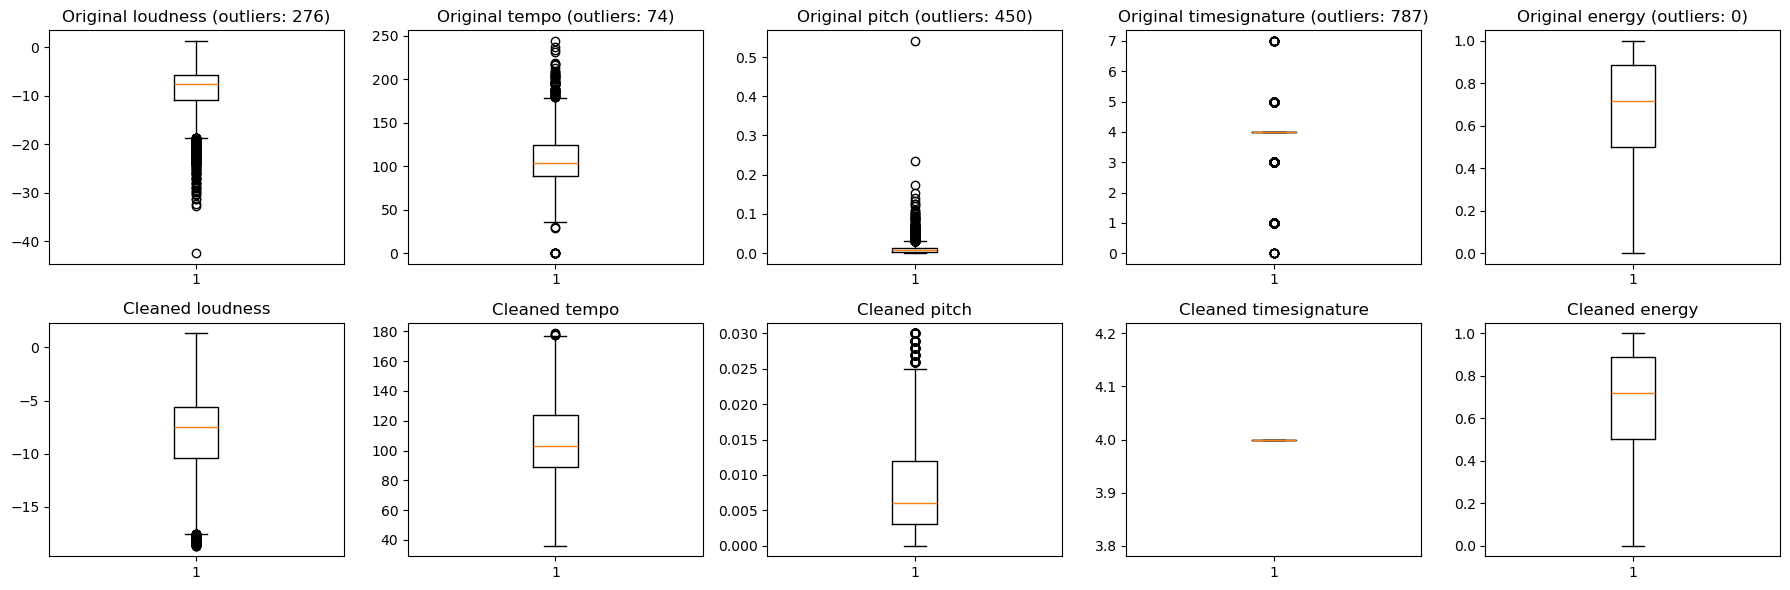


Number of rows after removing outliers: 7574

Class distribution in train_df['Top10']:
Top10
0    6141
1    1060
Name: count, dtype: int64
Optimization terminated successfully.
         Current function value: 0.324800
         Iterations 8

P-values from logistic regression model:
const    0.000000e+00
x1       3.203371e-19
x2       1.707070e-01
x3       1.136732e-04
x4       2.246597e-29
x5       5.367494e-01
x6       4.696627e-03
x7       2.194870e-01
x8       3.536835e-02
x9       1.757283e-08
x10      1.120485e-12
x11      4.177400e-11
x12      2.890773e-39
x13      2.795273e-11
x14      4.743696e-01
x15      5.423694e-01
x16      4.053704e-01
x17      1.629003e-01
x18      4.611994e-06
x19      1.841308e-07
x20      1.533402e-04
x21      1.006440e-05
x22      9.799191e-01
x23      3.060592e-13
x24      4.966727e-02
x25      8.795392e-04
x26      8.966105e-02
x27      9.716256e-02
x28      3.096433e-01
x29      8.361138e-01
x30      2.055440e-01
x31      1.080168e-01
x32      5.1

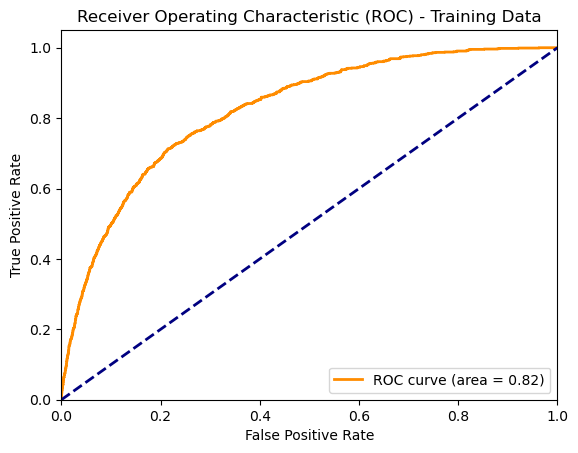


Testing Confusion Matrix:
[[314   0]
 [ 54   5]]
Test Accuracy: 0.8552
Test Precision: 1.0000
Test Recall: 0.0847
Test F1 Score: 0.1562


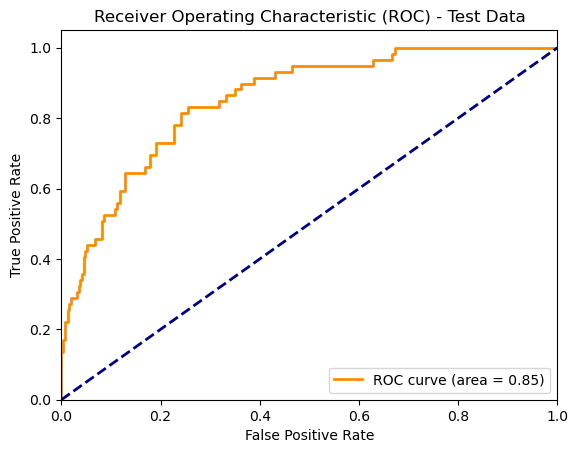

In [38]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE  # Import SMOTE for oversampling
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from scipy.stats import norm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the dataset
df = pd.read_csv("MusicData.csv", encoding='ISO-8859-1')

# Display count of null values for columns with more than 0 nulls
null_counts = df.isnull().sum()
print("\nColumns with more than 0 null values:")
print(null_counts[null_counts > 0])

# Removing unnecessary variables
df = df.drop(columns=['artistname', 'songtitle', 'songID', 'artistID'])
print(df.columns)

# Show initial class distribution to understand the problem
print("\nInitial class distribution in df['Top10']:")
print(df['Top10'].value_counts())

# Show count before outlier removal
print(f"\nNumber of rows before outlier removal: {df.shape[0]}")

# Improved function to identify and remove outliers using IQR
def identify_and_remove_outliers_iqr(df, column, iqr_factor=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_factor * IQR
    upper_bound = Q3 + iqr_factor * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    df_no_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return outliers, df_no_outliers

# List of columns to check for outliers
columns_to_check = ['loudness', 'tempo', 'pitch', 'timesignature', 'energy']

# Dictionary to store outliers
outliers_info = {}

# Apply outlier removal to all specified columns and visualize the effect
plt.figure(figsize=(18, 6))
for i, col in enumerate(columns_to_check, start=1):
    # Identify and remove outliers
    outliers, df_no_outliers = identify_and_remove_outliers_iqr(df, col)
    outliers_info[col] = outliers

    # Plotting boxplot for original data
    plt.subplot(2, len(columns_to_check), i)
    plt.boxplot(df[col], vert=True)
    plt.title(f'Original {col} (outliers: {len(outliers)})')
    
    # Plotting boxplot for data after outlier removal
    plt.subplot(2, len(columns_to_check), i + len(columns_to_check))
    plt.boxplot(df_no_outliers[col], vert=True)
    plt.title(f'Cleaned {col}')

plt.tight_layout()
plt.show()

# Update the main dataframe with outlier removal results
df = df_no_outliers

# Display number of rows after removing outliers
print(f"\nNumber of rows after removing outliers: {df.shape[0]}")

# Split data by year: train up to 2009, test on 2010
train_df = df[df['year'] <= 2009]
test_df = df[df['year'] == 2010]

# Check class distribution after splitting
print("\nClass distribution in train_df['Top10']:")
print(train_df['Top10'].value_counts())

# Prepare the training data
X_train = train_df.drop(columns="Top10")
y_train = train_df["Top10"]

# Prepare the testing data
X_test = test_df.drop(columns="Top10")
y_test = test_df["Top10"]

# Normalize features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add a constant column for the intercept for statsmodels logistic regression
X_train_sm = sm.add_constant(X_train_scaled, has_constant='add')

# Fit logistic regression model using statsmodels to get p-values
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

# Get p-values from the model
p_values = result.pvalues
print("\nP-values from logistic regression model:")
print(p_values)

# Identify features with p-values greater than 0.05
significant_features_indices = p_values[p_values <= 0.05].index.tolist()
print("\nSignificant features (p <= 0.05):")
print(significant_features_indices)

# Map indices back to feature names (excluding the intercept 'const')
if 'const' in significant_features_indices:
    significant_features_indices.remove('const')

# Get the corresponding feature names from the original dataset columns
significant_feature_names = [X_train.columns[int(idx[1:]) - 1] for idx in significant_features_indices]

print("\nSignificant feature names:")
print(significant_feature_names)

# Identify insignificant features (those not in the significant list)
insignificant_feature_names = [col for col in X_train.columns if col not in significant_feature_names]
print("\nInsignificant feature names (p > 0.05):")
print(insignificant_feature_names)

# Select only significant features
X_train_significant = X_train[significant_feature_names]
X_test_significant = X_test[significant_feature_names]

# Normalize significant features
X_train_significant_scaled = scaler.fit_transform(X_train_significant)
X_test_significant_scaled = scaler.transform(X_test_significant)

# Fit the logistic regression model again with significant features
log_reg = LogisticRegression(max_iter=10000, solver='lbfgs')
log_reg.fit(X_train_significant_scaled, y_train)

# Evaluate on the training set
y_train_pred_prob = log_reg.predict_proba(X_train_significant_scaled)[:, 1]
y_train_pred = (y_train_pred_prob > 0.5).astype(int)
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

print("\nTraining Confusion Matrix:")
print(train_conf_matrix)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train Recall: {train_recall:.4f}")
print(f"Train F1 Score: {train_f1:.4f}")

# ROC Curve and AUC for training data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Training Data')
plt.legend(loc="lower right")
plt.show()

# Evaluate on the test set
y_test_pred_prob = log_reg.predict_proba(X_test_significant_scaled)[:, 1]
y_test_pred = (y_test_pred_prob > 0.5).astype(int)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("\nTesting Confusion Matrix:")
print(test_conf_matrix)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# ROC Curve and AUC for test data
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Test Data')
plt.legend(loc="lower right")
plt.show()